# Turnstile jump in 2020
### Nov 7 2022

### two things are done in the following analysis :
#### data cleaning
- filter year
- remove zero value for entry and exit
- change column names 
- change value format for each column

#### calculate the net change for each station
- identify initial value
- identify ending value
- calculate the net change all year for all station
- calculate the money loss

#### problem: 
- result seems unresaonable. not sure why exit > entry, not the other way around.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import geopandas as gpd
from matplotlib import pyplot as plt

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns', None) # show all columns

In [2]:
df = pd.read_csv("data/Turnstile_Usage_Data__2020.csv")
df.Date = pd.to_datetime(df['Date'])
# df.Time = pd.to_datetime(df['Time'])

df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year
df['day'] = df.Date.dt.day
df['hour'] = df['Time'].apply(lambda x: x[:2]) # get hour

df['minute'] =  df['Time'].apply(lambda x: x[3:5])# get min
df['dow'] = df.Date.dt.dayofweek

print(df.shape)
print(df.month.nunique())

(13318000, 17)
12


## 1. sanity check

In [3]:
################################ 
#### pre-processing
################################ 
cols = list(df.columns)
for col in cols:
    #() you may find the year here is not only one as we expected. )
    print(col, df[col].nunique())

C/A 752
Unit 470
SCP 236
Station 379
Line Name 124
Division 6
Date 357
Time 83943
Description 2
Entries 5384671
Exits                                                      4889978
month 12
year 3
day 31
hour 24
minute 60
dow 7


In [4]:
df = df.loc[df['year'] == 2020]
print(df.shape) 

(13169542, 17)


In [5]:
# the exits and entries is in text rather than numeric format. 
# change both entries and exits.

df = df.rename(columns = {'Exits                                                     ':'Exits'})
df.Entries = df.Entries.apply(lambda x : x.replace(",", ""))
df.Exits = df.Exits.apply(lambda x : x.replace(",", ""))

df.Entries = pd.to_numeric(df.Entries)
df.Exits = pd.to_numeric(df.Exits)
df.hour = pd.to_numeric(df.hour)
df.minute = pd.to_numeric(df.minute)

In [6]:
##############
## remove entry/ exit = 0
##############

## after check the data, we found when entry/exit = 0, the cumulative counter in the opposite direction also does not work.
## so for net change accuracy, we first remove zero entries.
df = df.loc[~((df.Entries==0)|(df.Exits==0))]
print(df.shape) # the value is still large. We lost 5% data size.

(12470504, 17)


In [7]:
# For now, we are not going to remove the extrem large value, 
# since it is possible that the initialization value of the counter is large.
df.describe()

,Entries,Exits,month,year,day,hour,minute,dow
count,1.247050e+07,1.247050e+07,1.247050e+07,12470504.0,1.247050e+07,1.247050e+07,1.247050e+07,1.247050e+07
mean,4.467188e+07,3.696976e+07,6.360228e+00,2020.0,1.611794e+01,1.088512e+01,2.612385e+00,3.002408e+00
std,2.241885e+08,2.036400e+08,3.288821e+00,0.0,8.554938e+00,6.910638e+00,9.596235e+00,1.996404e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,2020.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.820418e+05,1.939510e+05,3.000000e+00,2020.0,9.000000e+00,5.000000e+00,0.000000e+00,1.000000e+00
50%,2.056409e+06,1.260428e+06,6.000000e+00,2020.0,1.700000e+01,1.100000e+01,0.000000e+00,3.000000e+00
75%,6.693000e+06,4.701275e+06,9.000000e+00,2020.0,2.300000e+01,1.600000e+01,0.000000e+00,5.000000e+00
max,2.128890e+09,2.123494e+09,1.200000e+01,2020.0,3.100000e+01,2.300000e+01,5.900000e+01,6.000000e+00


In [13]:
## For each booth, we'll use the earliest timestamp (e.g., 2020-1-1 00:00) as their initalization value.
f = df.sort_values(by = ['C/A','Unit','SCP','Date','hour','minute'], ascending = False)
f_end = f.drop_duplicates(['C/A','Unit','SCP','Date'], keep='first')
## check the ending status for each station. (e.g., at the end of the year, the entry/exit value for each station.)
f_begin = df.sort_values(['C/A','Unit','SCP','Date','hour','minute']).drop_duplicates(['C/A','Unit','SCP','Date'], keep='first')

## 2. net change calcualation

In [ ]:
##############
## calculate daily net change for each channel of each booth for each station.
##############

In [18]:
f_dif = f_begin[['C/A','Unit','SCP','Date','Entries','Exits','Station']].merge(\
        f_end[['C/A','Unit','SCP','Date','Entries','Exits']], \
        left_on = ['C/A','Unit','SCP','Date'],right_on = ['C/A','Unit','SCP','Date'], how = 'inner')
    
f_dif['ent_dif'] = f_dif['Entries_y'] - f_dif['Entries_x']
f_dif['ext_dif'] = f_dif['Exits_y'] - f_dif['Exits_x']
f_dif.columns = ['C/A','Unit','SCP','Date','Ent_beg','Ext_beg','Station','Ent_end','Ext_end','Ent_dif','Ext_dif']

f_dif.describe()

,Ent_beg,Ext_beg,Ent_end,Ext_end,Ent_dif,Ext_dif
count,1.645486e+06,1.645486e+06,1.645486e+06,1.645486e+06,1.645486e+06,1.645486e+06
mean,4.455633e+07,3.692240e+07,4.455868e+07,3.692305e+07,2.349192e+03,6.497812e+02
std,2.239969e+08,2.036084e+08,2.240045e+08,2.036094e+08,5.097496e+06,4.901952e+06
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.895327e+09,-2.048958e+09
25%,3.698198e+05,1.877612e+05,3.697452e+05,1.877522e+05,4.400000e+01,4.200000e+01
50%,2.017182e+06,1.238488e+06,2.016795e+06,1.238250e+06,1.650000e+02,1.450000e+02
75%,6.665002e+06,4.676429e+06,6.664838e+06,4.676177e+06,4.270000e+02,3.810000e+02
max,2.128890e+09,2.123494e+09,2.128890e+09,2.123493e+09,1.821543e+09,2.036332e+09


In [52]:
#######################
### sanity check for the net change
######################

## remove negative value - counter will always add number, 
## so the end state of a counter should always be larger than the begining state.
f_clean = f_dif.loc[(f_dif.Ent_dif >0)&(f_dif.Ext_dif>0)]
f_clean.shape

f_clean = f_clean[(f_clean['Ent_dif'] >= f_clean['Ent_dif'].quantile(0.003))& (\
              f_clean['Ent_dif'] <= f_clean['Ent_dif'].quantile(0.997))&(\
              f_clean['Ext_dif'] >= f_clean['Ext_dif'].quantile(0.003)) & (\
              f_clean['Ext_dif'] <= f_clean['Ext_dif'].quantile(0.997))] 
f_clean.shape

(1444226, 11)

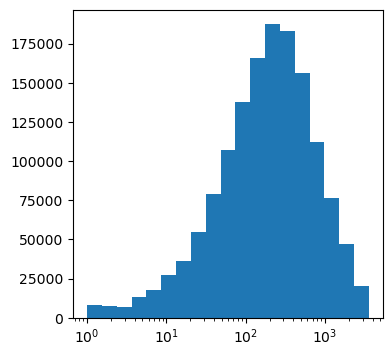

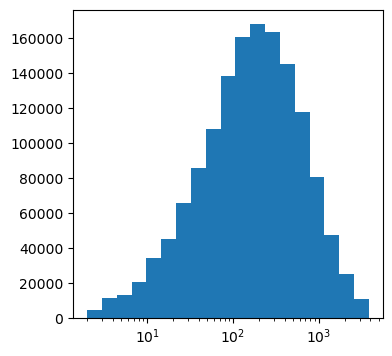

In [53]:
############################
## check cleaned data quality
#############################

def plot_loghist(x, bins): 
    #introduce a function for plotting a log-scale histogram
    #it ensures log-scale binning and label on the original scale
    logbins = np.logspace(np.log10(x.min()),np.log10(x.max()),bins)
    plt.hist(x, bins=logbins)
    plt.xscale('log')

# basically, it is log-normally distributed. 
for col in ['Ent_dif','Ext_dif']:
    fig, ax = plt.subplots(figsize = (4,4))
    plot_loghist(f_clean[col], bins = 20) 

In [54]:
###################
### urnstile jump results summarize
#############
f2.Ext_dif.sum() - f2.Ent_dif.sum()

-63566499

In [ ]:
####### problem forced to stop here: not sure why exit is less than entry. 
######## need to check and learn better later. 

### 4. to be continued
##### understand the outliers to help figure out the turnstile jump 

In [73]:
##############
## check patterns for outliers
##############


abn = f_dif.loc[(f_dif.Ent_dif <0)|(f_dif.Ext_dif<0)]
abn2 = abn
abn2['Ent_dif'] = abn2['Ent_dif'].apply(lambda x: -x if x <0 else x )
abn2['Ext_dif'] = abn2['Ext_dif'].apply(lambda x: -x if x <0 else x )

abn2

,C/A,Unit,SCP,Date,Ent_beg,Ext_beg,Station,Ent_end,Ext_end,Ent_dif,Ext_dif
3202,A002,R051,02-06-00,2020-02-13,82665,2847,59 ST,889,24,81776,2823
4904,A006,R079,00-00-04,2020-04-13,7896791,3415896,5 AV/59 ST,22,5,7896769,3415891
5222,A006,R079,00-03-00,2020-03-10,9437450,4099415,5 AV/59 ST,60,6,9437390,4099409
7362,A007,R079,01-06-03,2020-04-07,7832195,2864415,5 AV/59 ST,4,2,7832191,2864413
12192,A011,R080,01-03-00,2020-01-01,885742396,490064066,57 ST-7 AV,885741947,490062921,449,1145
...,...,...,...,...,...,...,...,...,...,...,...
1631904,R730,R431,00-00-04,2020-12-28,1559829504,1728236499,EASTCHSTER/DYRE,1559829383,1728236556,121,57
1631905,R730,R431,00-00-04,2020-12-29,1559829378,1728236558,EASTCHSTER/DYRE,1559829247,1728236631,131,73
1631906,R730,R431,00-00-04,2020-12-30,1559829244,1728236638,EASTCHSTER/DYRE,1559829128,1728236719,116,81
1631907,R730,R431,00-00-04,2020-12-31,1559829126,1728236725,EASTCHSTER/DYRE,1559829045,1728236780,81,55


In [97]:
# an example for outliers happen due to reset counters:

# test = f.loc[(f['C/A'] == 'A002')&(f['Unit'] == 'R051')&(f['SCP']=='02-00-00')&((f['C/A'] == 'A002')&(f['month']==9))]
# test = test.reset_index()
# test.iloc[70:90,] # the abnormal volume difference is due to counter reset (i.e., description = recover Aud)